<a href="https://colab.research.google.com/github/VicenteB2004/Cine_Uleam/blob/main/Algoritmo%20XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np

# --- Cargar los archivos base ---
ruta_temp = '/content/drive/MyDrive/Colab Notebooks/Datos procesados/Temperatura.csv'
ruta_preci = '/content/drive/MyDrive/Colab Notebooks/Datos procesados/precipitacion.csv'  # cuidado con la mayúscula

# Leer los archivos con codificación compatible
temp = pd.read_csv(ruta_temp, encoding='latin1')
preci = pd.read_csv(ruta_preci, encoding='latin1')

print("✅ Archivos cargados correctamente")
print("Columnas Temperatura:", temp.columns.tolist())
print("Columnas Precipitación:", preci.columns.tolist())

# --- Normalizamos nombres de columnas ---
temp.columns = temp.columns.str.strip()
preci.columns = preci.columns.str.strip()

# --- Unimos los datasets por Departamento y Municipio ---
merged = pd.merge(temp, preci, on=["Departamento", "Municipio"], how="inner")

# --- Crear variable de HUMEDAD ---
# Se simula una relación: mayor precipitación → mayor humedad; mayor temperatura → menor humedad
merged["Humedad_prom"] = (
    (merged["prec_pro"] * 0.6) + (100 - merged["temp_pro"]) * 0.4
).clip(0, 100)  # limitamos entre 0% y 100%

# Calcular humedad mínima y máxima con algo de variación aleatoria
merged["Humedad_min"] = (merged["Humedad_prom"] - np.random.uniform(2, 5, len(merged))).clip(0, 100)
merged["Humedad_max"] = (merged["Humedad_prom"] + np.random.uniform(2, 5, len(merged))).clip(0, 100)

# --- Añadimos columna de Cultivo (si existía en alguno de los dos) ---
if "Cultivo" in temp.columns:
    merged["Cultivo"] = temp["Cultivo"]
elif "Cultivo" in preci.columns:
    merged["Cultivo"] = preci["Cultivo"]
else:
    # Si no existe, asignamos cultivos de ejemplo
    cultivos = ["Maíz", "Cacao", "Banano", "Café", "Yuca"]
    merged["Cultivo"] = np.random.choice(cultivos, size=len(merged))

# --- Seleccionamos columnas finales ---
humedad = merged[["Departamento", "Municipio", "Humedad_min", "Humedad_max", "Humedad_prom", "Cultivo"]]

# --- Guardamos el archivo final ---
ruta_salida = '/content/drive/MyDrive/Colab Notebooks/Datos procesados/Humedad.csv'
humedad.to_csv(ruta_salida, index=False, encoding='utf-8-sig')

print("✅ Archivo 'Humedad.csv' creado correctamente en tu Drive.")
print(humedad.head())


✅ Archivos cargados correctamente
Columnas Temperatura: ['Departamento', 'Municipio', 'temp_min', 'temp_max', 'temp_pro']
Columnas Precipitación: ['Departamento', 'Municipio', 'prec_min', 'prec_max', 'prec_pro']
✅ Archivo 'Humedad.csv' creado correctamente en tu Drive.
  Departamento      Municipio  Humedad_min  Humedad_max  Humedad_prom Cultivo
0     AMAZONAS        LETICIA    27.069020    34.878189     29.940336    Maíz
1     AMAZONAS  PUERTO NARIÑO    26.736865    32.776704     30.362430  Banano
2    ANTIOQUIA      ANGOSTURA    30.068314    36.796842     32.887661    Café
3    ANTIOQUIA         CAREPA    26.558890    33.120995     30.116025    Café
4    ANTIOQUIA      CHIGORODÓ    24.995149    33.479103     29.688218    Maíz


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Datos cargados correctamente
  Departamento      Municipio  Humedad_min  Humedad_max  Humedad_prom Cultivo
0     AMAZONAS        LETICIA    27.069020    34.878189     29.940336    Maíz
1     AMAZONAS  PUERTO NARIÑO    26.736865    32.776704     30.362430  Banano
2    ANTIOQUIA      ANGOSTURA    30.068314    36.796842     32.887661    Café
3    ANTIOQUIA         CAREPA    26.558890    33.120995     30.116025    Café
4    ANTIOQUIA      CHIGORODÓ    24.995149    33.479103     29.688218    Maíz
Columnas totales: 6
✅ Variable objetivo codificada correctamente.
Número de clases: 5
Ejemplo de clases: ['Banano' 'Cacao' 'Café' 'Maíz' 'Yuca']
✅ Clases filtradas: 5 (de 5)
Filas finales después del filtrado: 278
✅ Etiquetas reindexadas correctamente. Total de clases: 5
Entrenando modelo XGBoost... ⏳
✅ Entrenamiento completado

🔹 Exactitud (Accuracy): 0.125

🔹 Reporte 

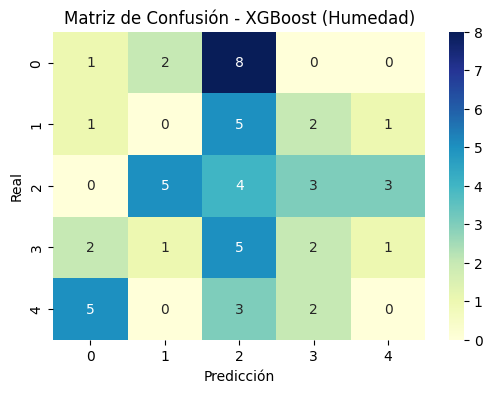

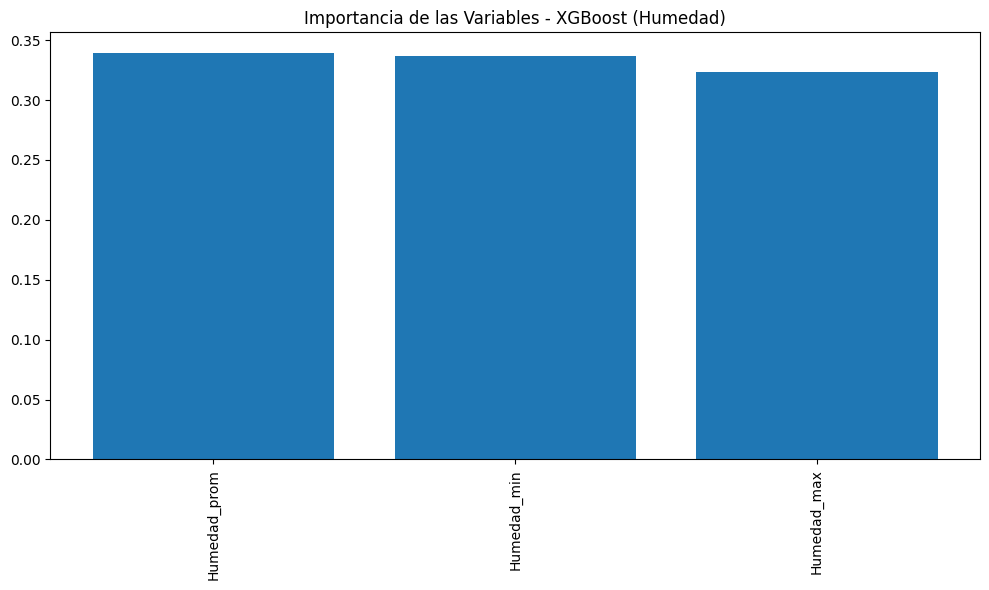


✅ CONCLUSIÓN:
El modelo XGBoost fue entrenado utilizando datos de HUMEDAD.
Se filtraron las clases con pocos registros para mejorar la estabilidad del modelo.
Puedes ajustar los hiperparámetros para mejorar la precisión, como:
- max_depth (profundidad del árbol)
- learning_rate (tasa de aprendizaje)
- n_estimators (número de árboles)



In [9]:
# --- 1. MONTAJE DEL DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- 2. IMPORTAR LIBRERÍAS ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. CARGAR LOS DATOS ---
ruta_datos = '/content/drive/MyDrive/Colab Notebooks/Datos procesados/Humedad.csv'  # 📌 nuevo archivo base
data = pd.read_csv(ruta_datos)
print("✅ Datos cargados correctamente")
print(data.head())
print("Columnas totales:", len(data.columns))

# --- 4. LIMPIEZA Y PREPARACIÓN DE DATOS ---
# Reemplazar 'ND' por NaN y luego rellenar con 0
data = data.replace("ND", np.nan)
data = data.fillna(0)

# Variable objetivo (cultivo)
y = data['Cultivo']

# Variables predictoras: columnas numéricas relacionadas con humedad
X = data.select_dtypes(include=[np.number])

# Codificación de la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("✅ Variable objetivo codificada correctamente.")
print("Número de clases:", len(le.classes_))
print("Ejemplo de clases:", le.classes_[:10])

# --- 5. FILTRAR CLASES CON POCOS REGISTROS ---
y_series = pd.Series(y_encoded)
frecuencias = y_series.value_counts()
clases_validas = frecuencias[frecuencias >= 5].index

X_filtrado = X[y_series.isin(clases_validas)]
y_filtrado = y_series[y_series.isin(clases_validas)]

print(f"✅ Clases filtradas: {len(clases_validas)} (de {len(le.classes_)})")
print("Filas finales después del filtrado:", len(X_filtrado))

# --- 6. DIVISIÓN DE DATOS ---
X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y_filtrado, test_size=0.2, random_state=42, stratify=y_filtrado
)

# --- 7. REINDEXAR CLASES ---
le2 = LabelEncoder()
y_train = le2.fit_transform(y_train)
y_test = le2.transform(y_test)

num_clases = len(le2.classes_)
print(f"✅ Etiquetas reindexadas correctamente. Total de clases: {num_clases}")

# --- 8. CREACIÓN Y ENTRENAMIENTO DEL MODELO ---
model = XGBClassifier(
    objective='multi:softmax',  # clasificación multiclase
    num_class=num_clases,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    random_state=42
)

print("Entrenando modelo XGBoost... ⏳")
model.fit(X_train, y_train)
print("✅ Entrenamiento completado")

# --- 9. PREDICCIONES Y MÉTRICAS ---
y_pred = model.predict(X_test)

print("\n🔹 Exactitud (Accuracy):", round(accuracy_score(y_test, y_pred), 3))
print("\n🔹 Reporte de Clasificación:\n", classification_report(y_test, y_pred))

# --- 10. MATRIZ DE CONFUSIÓN ---
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title('Matriz de Confusión - XGBoost (Humedad)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# --- 11. IMPORTANCIA DE VARIABLES ---
plt.figure(figsize=(10,6))
xgb_importances = model.feature_importances_
indices = np.argsort(xgb_importances)[::-1]

plt.bar(range(len(X.columns)), xgb_importances[indices])
plt.xticks(range(len(X.columns)), X.columns[indices], rotation=90)
plt.title('Importancia de las Variables - XGBoost (Humedad)')
plt.tight_layout()
plt.show()

# --- 12. CONCLUSIÓN ---
print("""
✅ CONCLUSIÓN:
El modelo XGBoost fue entrenado utilizando datos de HUMEDAD.
Se filtraron las clases con pocos registros para mejorar la estabilidad del modelo.
Puedes ajustar los hiperparámetros para mejorar la precisión, como:
- max_depth (profundidad del árbol)
- learning_rate (tasa de aprendizaje)
- n_estimators (número de árboles)
""")
